In [1]:

!pip install pyspark seaborn matplotlib

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from pyspark.sql import functions as F
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [2]:

spark = SparkSession.builder.master("local[*]").appName("SalesVisualization").getOrCreate()

In [3]:


schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

In [33]:
data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]


In [8]:

df = spark.createDataFrame(data, schema)
df.show(10, truncate=False)


+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



In [9]:

output_dir = "/content/sales_viz"
os.makedirs(output_dir, exist_ok=True)

In [10]:

df = df.withColumn("revenue", F.col("quantity") * F.col("price"))

In [11]:


pdf = df.toPandas()


#Bar chart - Total revenue by category

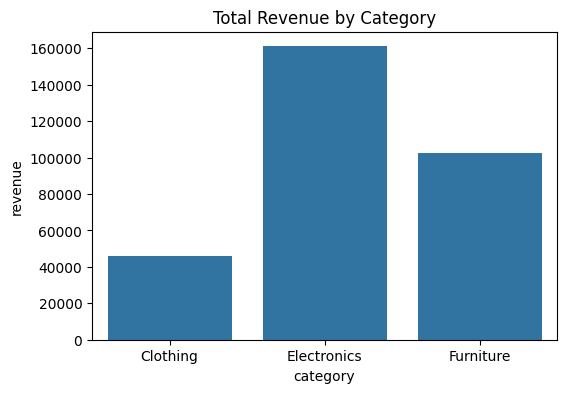

In [24]:
plt.figure(figsize=(6,4))
sns.barplot(data=pdf.groupby("category", as_index=False)["revenue"].sum(), x="category", y="revenue")
plt.title("Total Revenue by Category")
plt.savefig(f"{output_dir}/revenue_by_category.png")
plt.show()

#Line chart - Revenue trend by order_date

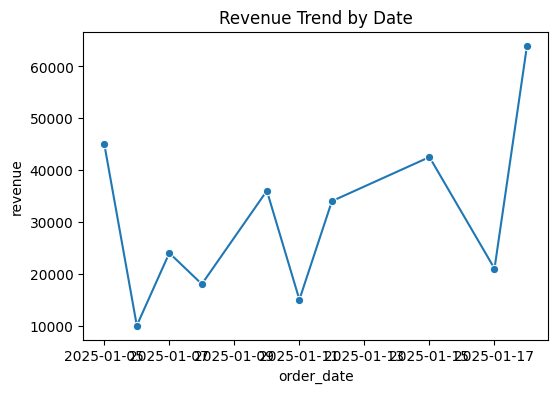

In [25]:
plt.figure(figsize=(6,4))
trend = pdf.groupby("order_date", as_index=False)["revenue"].sum().sort_values("order_date")
sns.lineplot(data=trend, x="order_date", y="revenue", marker="o")
plt.title("Revenue Trend by Date")
plt.savefig(f"{output_dir}/revenue_trend.png")
plt.show()

#Pie chart - Revenue by region

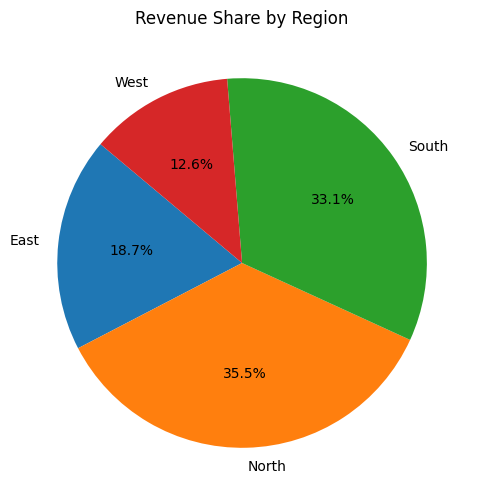

In [26]:

region_rev = pdf.groupby("region")["revenue"].sum()
plt.figure(figsize=(6,6))
plt.pie(region_rev, labels=region_rev.index, autopct="%1.1f%%", startangle=140)
plt.title("Revenue Share by Region")
plt.savefig(f"{output_dir}/revenue_by_region_pie.png")
plt.show()

#Stacked bar chart - Quantity per category by region

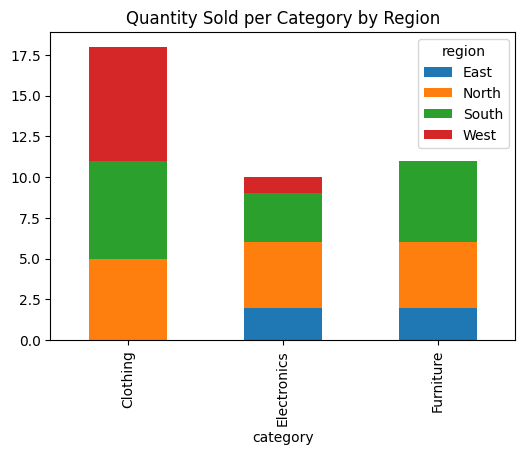

In [27]:
stack_data = pdf.groupby(["category", "region"])["quantity"].sum().unstack(fill_value=0)
stack_data.plot(kind="bar", stacked=True, figsize=(6,4))
plt.title("Quantity Sold per Category by Region")
plt.savefig(f"{output_dir}/stacked_quantity.png")
plt.show()

#Top 5 orders by revenue - horizontal bar


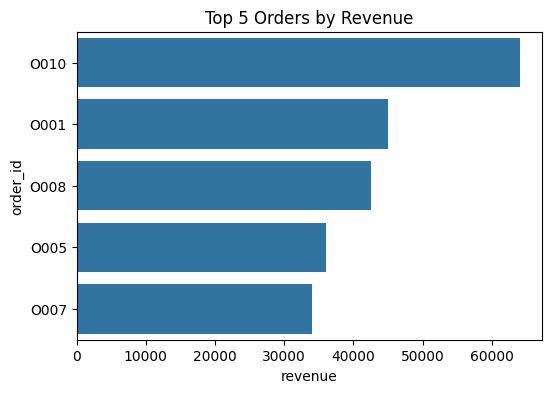

In [28]:
top5 = pdf.groupby("order_id", as_index=False)["revenue"].sum().sort_values("revenue", ascending=False).head(5)
plt.figure(figsize=(6,4))
sns.barplot(data=top5, y="order_id", x="revenue", orient="h")
plt.title("Top 5 Orders by Revenue")
plt.savefig(f"{output_dir}/top5_orders.png")
plt.show()

#Scatter plot - Quantity vs Price by category

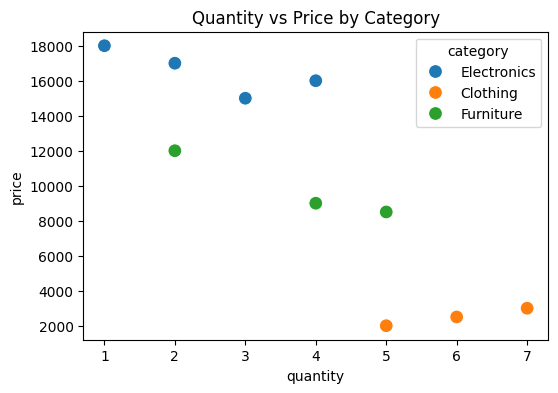

In [29]:

plt.figure(figsize=(6,4))
sns.scatterplot(data=pdf, x="quantity", y="price", hue="category", s=100)
plt.title("Quantity vs Price by Category")
plt.savefig(f"{output_dir}/scatter_qty_price.png")
plt.show()


# Average order value by region

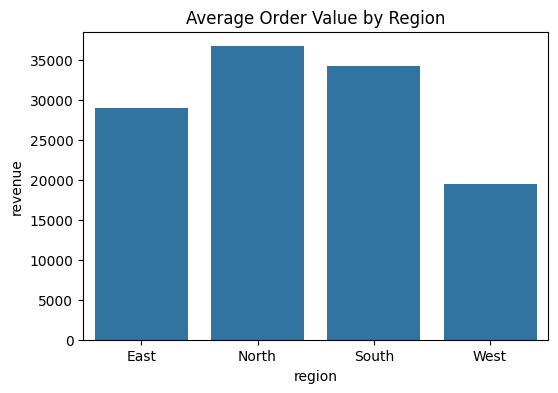

In [30]:
avg_order_value = pdf.groupby("region")["revenue"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=avg_order_value, x="region", y="revenue")
plt.title("Average Order Value by Region")
plt.savefig(f"{output_dir}/avg_order_value.png")
plt.show()

# Heatmap - Revenue by region & category

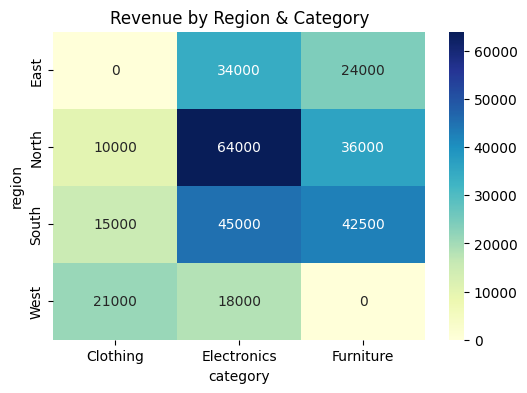

In [31]:


heat_data = pdf.groupby(["region", "category"])["revenue"].sum().unstack(fill_value=0)
plt.figure(figsize=(6,4))
sns.heatmap(heat_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue by Region & Category")
plt.savefig(f"{output_dir}/heatmap.png")
plt.show()


#Bonus - Discounted vs Original revenue

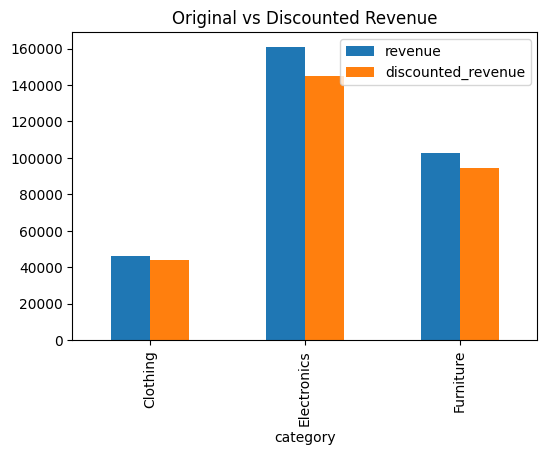

✅ All charts saved and displayed. Files in: /content/sales_viz


In [32]:

discount_map = {"Electronics": 0.10, "Clothing": 0.05, "Furniture": 0.08}
pdf["discount"] = pdf["category"].map(discount_map)
pdf["discounted_revenue"] = pdf["revenue"] * (1 - pdf["discount"])
comp_data = pdf.groupby("category")[["revenue", "discounted_revenue"]].sum().reset_index()
comp_data.plot(x="category", kind="bar", figsize=(6,4))
plt.title("Original vs Discounted Revenue")
plt.savefig(f"{output_dir}/discount_comparison.png")
plt.show()

print(f"✅ All charts saved and displayed. Files in: {output_dir}")